In [1]:
import sys
import os
from data_utils import *
from ml_utils import *
import numpy
import keras
from matplotlib import pyplot as plt
%matplotlib inline

numpy.random.seed()

DATA_DIR = "./data/"
SAMPLE = False

Using TensorFlow backend.


Some notes about the dat

    1. I didn't find region data in the github dataset (maybe I just missed it). So I had to use some all US measures for weather. Likley that kill most of the interesting stuff (if there is any)

    2. There are strong correlations between weather and date. Github commit are obviously very date dependant.
 ______________________
 
What I would have done, (with more time and computing power)
 
   1. Better features:
   
      a. I could probably used better features related to the year.
   
      b. I could split the weather data by state (likely some states are more rellevant).
      
   2. Better models:
      
       a. I didn't have time to scan over network archicteture.
       
       c. I am pretty sure simple ML techniques could do a good job here. For instance a regresssion Tree. 
       
          
   3. The extrapolation problem -
    
       Treating the commits data as a time series, is much more sensible and should allow some prediction into the future. Of course with finite prediction horizon.
    
  

# get the data

In [2]:
fname = os.path.normpath(os.path.join(DATA_DIR,'commits.json.gz'))
if SAMPLE:
    fname = fname.replace('commits','commits_sample')
if not(os.path.exists(fname)):
    query_data(SAMPLE)
    print("query finished")
else:
     print("skipping query")   

skipping query


In [3]:
labels,feat_x,feat_t,key2index = load_data(fname)

loading  data/commits.json.gz
loading  data/weather_2017.json.gz


deleting lines with no weather data

In [4]:
IQ = feat_x.sum(axis=1)!=0
labels = labels[IQ,:]
feat_x = feat_x[IQ,:]
feat_t = feat_t[IQ,:]

There is some anomaly in the data from September 2005, I am going to ignore it just for fun (let the NN have some hard time)

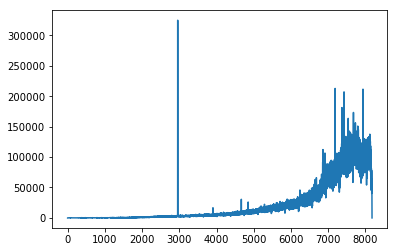

In [5]:
plt.plot(labels[:,0]-labels[0,0],labels[:,1])

# Interpolation

Ignoring the time-series property of the data,

I am going to try and predict the commit count using only weather and date data.

I am going to split the data into 4 sets:

     future (2017)

     train (60%,<2017)

     dev(20%,<2017)
  
     test(20%,<2017)


In [6]:
RI = numpy.random.randint(0,5,feat_x.shape[0])
IQ = numpy.logical_and(feat_t[:,0]!=2017,RI<3)
train = (feat_x[IQ,:],feat_t[IQ,:],labels[IQ,:])

IQ = numpy.logical_and(feat_t[:,0]!=2017,RI==3)
dev = (feat_x[IQ,:],feat_t[IQ,:],labels[IQ,:])

IQ = numpy.logical_and(feat_t[:,0]!=2017,RI==4)
test = (feat_x[IQ,:],feat_t[IQ,:],labels[IQ,:])

IQ = feat_t[:,0]==2017
future = (feat_x[IQ,:],feat_t[IQ,:],labels[IQ,:])

for s in [train,dev,test,future]:
    print(s[0].shape)

(4795, 369)
(1661, 369)
(1580, 369)
(141, 369)


### lets build some simple feed-forward Networks models

In [7]:
x,fx,ifx  = normalize(train[0])
y,fy,ify  = normalize(train[1])
z,fz,ifz  = normalize_output(train[2])

X_train,Z_train = shuffle_list((numpy.hstack([x,y]),z))

X_dev = numpy.hstack([fx(dev[0]),fy(dev[1])])
Z_dev = fz(dev[2])

X_test = numpy.hstack([fx(test[0]),fy(test[1])])
X_fut = numpy.hstack([fx(future[0]),fy(future[1])])


In [8]:
# Some arbitrary choice to limit the space of networks

def rand_struct(max_depth,num_of_params):
    min_params_per_layer = 5
    num_params = max_depth * num_of_params
    layers = list()
    for l in range(max_depth-1):
        p = numpy.random.randint(min_params_per_layer,num_params-min_params_per_layer*(max_depth-l))
        layers.append(p)
        num_params-=p
    layers.append(num_params)
    return layers

def build_model(X,Z,max_depth,number_of_parameters,epochs=24):
    layers = rand_struct(max_depth,number_of_parameters)
    print(layers)
    model = keras.models.Sequential()
    last_size = X.shape[1]
    for l in layers:
        model.add(keras.layers.Dense(units = l,
                                     input_shape = (last_size,),
                                     activation='relu',
                                     use_bias = True))
        last_size = l
    model.add(keras.layers.Dense(units=1,
                                 input_shape = (last_size,),
                                 activation = 'linear',
                                 use_bias = True))
    model.compile(optimizer='adam',
                  loss='mean_squared_error')   #Such a bad choice for optimization for this small problem ...
    model.fit(X,Z,
              batch_size=int(X.shape[0]/8),
              shuffle = False,
              validation_split = 0.1,
              epochs = epochs) 
    # the stopping condition is not great, I have no time to fix this ...
    return model

[4843, 910, 80, 391]
Train on 4315 samples, validate on 480 samples
Epoch 1/12
4315/4315 [==============================] - 8s - loss: 0.8473 - val_loss: 0.1239
Epoch 2/12
4315/4315 [==============================] - 8s - loss: 0.1048 - val_loss: 0.0994
Epoch 3/12
4315/4315 [==============================] - 8s - loss: 0.0580 - val_loss: 0.0549
Epoch 4/12
4315/4315 [==============================] - 8s - loss: 0.0359 - val_loss: 0.0410
Epoch 5/12
4315/4315 [==============================] - 8s - loss: 0.0278 - val_loss: 0.0331
Epoch 6/12
4315/4315 [==============================] - 8s - loss: 0.0239 - val_loss: 0.0341
Epoch 7/12
4315/4315 [==============================] - 8s - loss: 0.0224 - val_loss: 0.0381
Epoch 8/12
4315/4315 [==============================] - 8s - loss: 0.0228 - val_loss: 0.0337
Epoch 9/12
4315/4315 [==============================] - 8s - loss: 0.0196 - val_loss: 0.0272
Epoch 10/12
4315/4315 [==============================] - 8s - loss: 0.0162 - val_loss: 0.0292
E

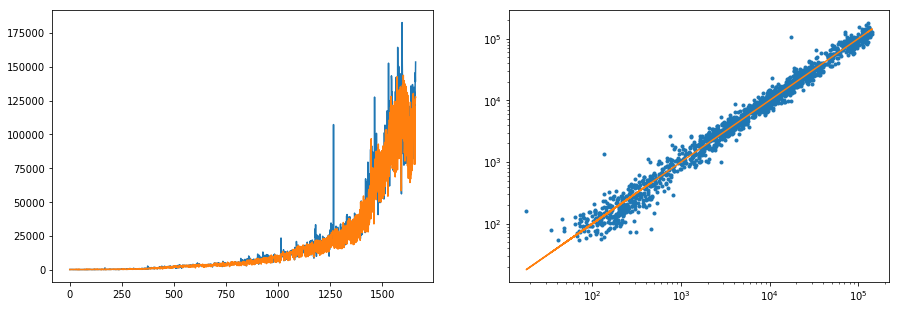

In [9]:
"""
Let's see that a single model works
"""
model = build_model(X_train,Z_train,4,X_train.shape[1]*4,epochs=12)
p = ifz(model.predict(X_dev))
p[p>1E6] = 0   

f, axarr = plt.subplots(1, 2,figsize=(15,5))
axarr[0].plot(p)
axarr[0].plot(dev[2][:,1])
axarr[1].loglog(dev[2][:,1],p,'.')
axarr[1].loglog(dev[2][:,1],dev[2][:,1],'-')


In [10]:
"""
Let's get a bunch of models

We will weight the models by the dev loss function

"""

ensemble_size = 16       #just is not enough, but I am cheap about computing time
max_depth = 4
num_params = X_train.shape[1] * 4
epochs = 16 
models = list()
losses = list()
for i in range(ensemble_size):
    print("start model %d"%i)
    m = build_model(X_train,Z_train,max_depth,num_params,epochs)
    p = numpy.linalg.norm(m.predict(X_dev)-Z_dev)
    models.append(m)
    losses.append(p)
weights = 1/(1+numpy.array(losses))
weights = weights/weights.sum()

start model 0
[4959, 268, 94, 903]
Train on 4315 samples, validate on 480 samples
Epoch 1/16
4315/4315 [==============================] - 4s - loss: 0.6611 - val_loss: 0.1627
Epoch 2/16
4315/4315 [==============================] - 4s - loss: 0.0991 - val_loss: 0.0698
Epoch 3/16
4315/4315 [==============================] - 4s - loss: 0.0515 - val_loss: 0.0444
Epoch 4/16
4315/4315 [==============================] - 4s - loss: 0.0323 - val_loss: 0.0418
Epoch 5/16
4315/4315 [==============================] - 4s - loss: 0.0267 - val_loss: 0.0393
Epoch 6/16
4315/4315 [==============================] - 4s - loss: 0.0234 - val_loss: 0.0334
Epoch 7/16
4315/4315 [==============================] - 4s - loss: 0.0193 - val_loss: 0.0300
Epoch 8/16
4315/4315 [==============================] - 4s - loss: 0.0161 - val_loss: 0.0296
Epoch 9/16
4315/4315 [==============================] - 4s - loss: 0.0145 - val_loss: 0.0260
Epoch 10/16
4315/4315 [==============================] - 4s - loss: 0.0125 - val_

4315/4315 [==============================] - 13s - loss: 0.4366 - val_loss: 0.3368
Epoch 3/16
4315/4315 [==============================] - 12s - loss: 0.1521 - val_loss: 0.0827
Epoch 4/16
4315/4315 [==============================] - 12s - loss: 0.0728 - val_loss: 0.0607
Epoch 5/16
4315/4315 [==============================] - 12s - loss: 0.0484 - val_loss: 0.0491
Epoch 6/16
4315/4315 [==============================] - 12s - loss: 0.0356 - val_loss: 0.0393
Epoch 7/16
4315/4315 [==============================] - 12s - loss: 0.0265 - val_loss: 0.0371
Epoch 8/16
4315/4315 [==============================] - 12s - loss: 0.0235 - val_loss: 0.0332
Epoch 9/16
4315/4315 [==============================] - 12s - loss: 0.0202 - val_loss: 0.0302
Epoch 10/16
4315/4315 [==============================] - 12s - loss: 0.0184 - val_loss: 0.0286
Epoch 11/16
4315/4315 [==============================] - 12s - loss: 0.0165 - val_loss: 0.0279
Epoch 12/16
4315/4315 [==============================] - 12s - loss: 

4315/4315 [==============================] - 12s - loss: 0.1071 - val_loss: 0.0362
Epoch 5/16
4315/4315 [==============================] - 12s - loss: 0.0380 - val_loss: 0.0613
Epoch 6/16
4315/4315 [==============================] - 12s - loss: 0.0378 - val_loss: 0.0962
Epoch 7/16
4315/4315 [==============================] - 12s - loss: 0.0513 - val_loss: 0.0469
Epoch 8/16
4315/4315 [==============================] - 12s - loss: 0.0519 - val_loss: 0.0733
Epoch 9/16
4315/4315 [==============================] - 12s - loss: 0.0561 - val_loss: 0.0575
Epoch 10/16
4315/4315 [==============================] - 12s - loss: 0.0443 - val_loss: 0.0615
Epoch 11/16
4315/4315 [==============================] - 12s - loss: 0.0324 - val_loss: 0.0344
Epoch 12/16
4315/4315 [==============================] - 12s - loss: 0.0194 - val_loss: 0.0288
Epoch 13/16
4315/4315 [==============================] - 12s - loss: 0.0145 - val_loss: 0.0273
Epoch 14/16
4315/4315 [==============================] - 11s - loss

4315/4315 [==============================] - 13s - loss: 0.0284 - val_loss: 0.0398
Epoch 7/16
4315/4315 [==============================] - 13s - loss: 0.0237 - val_loss: 0.0373
Epoch 8/16
4315/4315 [==============================] - 13s - loss: 0.0212 - val_loss: 0.0345
Epoch 9/16
4315/4315 [==============================] - 13s - loss: 0.0188 - val_loss: 0.0321
Epoch 10/16
4315/4315 [==============================] - 13s - loss: 0.0167 - val_loss: 0.0307
Epoch 11/16
4315/4315 [==============================] - 13s - loss: 0.0153 - val_loss: 0.0294
Epoch 12/16
4315/4315 [==============================] - 13s - loss: 0.0140 - val_loss: 0.0288
Epoch 13/16
4315/4315 [==============================] - 13s - loss: 0.0130 - val_loss: 0.0280
Epoch 14/16
4315/4315 [==============================] - 13s - loss: 0.0124 - val_loss: 0.0287
Epoch 15/16
4315/4315 [==============================] - 13s - loss: 0.0116 - val_loss: 0.0270
Epoch 16/16
4315/4315 [==============================] - 13s - lo

### evaluation

#### test set

15
 0. mean square error =  12804.2770428
 1. mean square error =  9703.39777075
 2. mean square error =  9654.52311562
 3. mean square error =  8729.36443525
 4. mean square error =  13472.9287125
 5. mean square error =  8651.71853903
 6. mean square error =  9446.90969351
 7. mean square error =  21014.0679919
 8. mean square error =  7971.15560685
 9. mean square error =  7741.8249675
10. mean square error =  12907.1021867
11. mean square error =  9968.69365977
12. mean square error =  9944.69093296
13. mean square error =  8296.7234135
14. mean square error =  10434.0929171
15. mean square error =  7916.98505137
ensemble mean square error =  8571.01558048


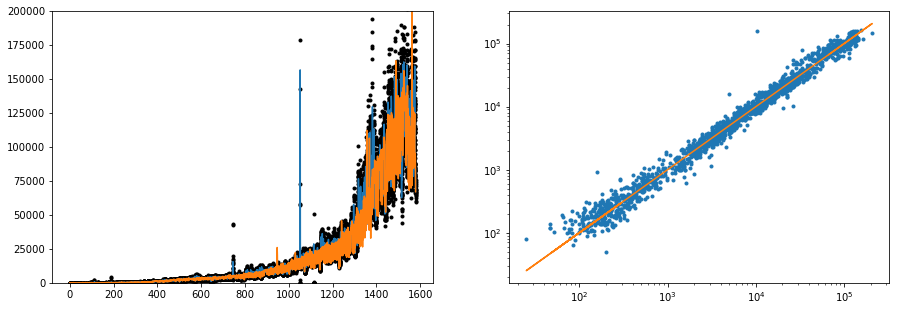

In [11]:
testset = (X_test,test[2][:,1])

results  = numpy.zeros((testset[0].shape[0],len(models)),dtype=numpy.float)
i=0
for m in models:
    print("\r%d"%i,end="",flush=True)
    u = ifz(m.predict(testset[0]))[:,0]
    results[:,i] = u
    i+=1
results[results>1E6]=0
avg_result = results.dot(weights)
print("")
f, axarr = plt.subplots(1, 2,figsize=(15,5))
for i in range(results.shape[1]):
    axarr[0].plot(results[:,i],'.k')    
    print('%2d. mean square error = '%i,numpy.sqrt(numpy.mean(numpy.power(testset[1]-results[:,i],2))))
axarr[0].plot(avg_result)
axarr[0].plot(testset[1])
axarr[0].set_ylim(0,200000)
axarr[1].loglog(testset[1],avg_result,'.'),
axarr[1].loglog(testset[1],testset[1],'-')

print('ensemble mean square error = ',numpy.sqrt(numpy.mean(numpy.power(testset[1]-avg_result,2))))

#### future set

2

/home/dori/gitweather/ml_utils.py:21: RuntimeWarning: overflow encountered in expm1
  ifun = lambda z: numpy.expm1(z*s+m)


15
 0. mean square error =  35514.6659781
 1. mean square error =  42891.7450186
 2. mean square error =  36622.0118153
 3. mean square error =  27859.1451546
 4. mean square error =  32260.6588716
 5. mean square error =  30181.0747098
 6. mean square error =  28366.8520968
 7. mean square error =  33987.6877661
 8. mean square error =  27526.6615907
 9. mean square error =  24631.0389525
10. mean square error =  29265.6727294
11. mean square error =  26591.7808372
12. mean square error =  20314.2070372
13. mean square error =  30677.4562034
14. mean square error =  29761.7315141
15. mean square error =  30963.1860142
ensemble mean square error =  28330.4456057


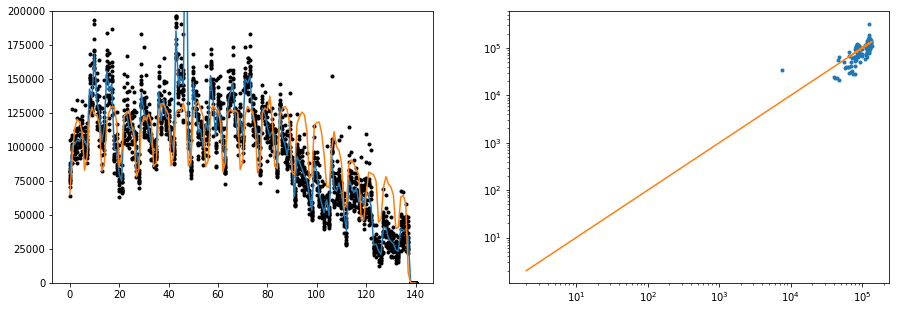

In [12]:
testset = (X_fut,future[2][:,1])

results  = numpy.zeros((testset[0].shape[0],len(models)),dtype=numpy.float)
i=0
for m in models:
    print("\r%d"%i,end="",flush=True)
    u = ifz(m.predict(testset[0]))[:,0]
    results[:,i] = u
    i+=1
results[results>1E6]=0
avg_result = results.dot(weights)
print("")
f, axarr = plt.subplots(1, 2,figsize=(15,5))
for i in range(results.shape[1]):
    axarr[0].plot(results[:,i],'.k')    
    print('%2d. mean square error = '%i,numpy.sqrt(numpy.mean(numpy.power(testset[1]-results[:,i],2))))
axarr[0].plot(avg_result)
axarr[0].plot(testset[1])
axarr[0].set_ylim(0,200000)
axarr[1].loglog(testset[1],avg_result,'.'),
axarr[1].loglog(testset[1],testset[1],'-')

print('ensemble mean square error = ',numpy.sqrt(numpy.mean(numpy.power(testset[1]-avg_result,2))))

### Let's try again without weather data

In [13]:
X_train2,Z_train2 = shuffle_list((numpy.hstack([y]),z))

X_dev2 = numpy.hstack([fy(dev[1])])
Z_dev2 = fz(dev[2])

X_test2 = numpy.hstack([fy(test[1])])
X_fut2 = numpy.hstack([fy(future[1])])

In [14]:
models2 = list()
losses2 = list()
for i in range(ensemble_size):
    print("start model %d"%i)
    m = build_model(X_train2,Z_train2,max_depth,num_params,epochs)
    p = numpy.linalg.norm(m.predict(X_dev2)-Z_dev2)
    models2.append(m)
    losses2.append(p)
weights2 = 1/(1+numpy.array(losses2))
weights2 = weights2/weights2.sum()

start model 0
[4944, 481, 499, 300]
Train on 4315 samples, validate on 480 samples
Epoch 1/16
4315/4315 [==============================] - 4s - loss: 0.6755 - val_loss: 0.1068
Epoch 2/16
4315/4315 [==============================] - 4s - loss: 0.0967 - val_loss: 0.0926
Epoch 3/16
4315/4315 [==============================] - 4s - loss: 0.0445 - val_loss: 0.0321
Epoch 4/16
4315/4315 [==============================] - 4s - loss: 0.0250 - val_loss: 0.0286
Epoch 5/16
4315/4315 [==============================] - 4s - loss: 0.0182 - val_loss: 0.0223
Epoch 6/16
4315/4315 [==============================] - 4s - loss: 0.0152 - val_loss: 0.0216
Epoch 7/16
4315/4315 [==============================] - 4s - loss: 0.0129 - val_loss: 0.0217
Epoch 8/16
4315/4315 [==============================] - 4s - loss: 0.0120 - val_loss: 0.0196
Epoch 9/16
4315/4315 [==============================] - 4s - loss: 0.0113 - val_loss: 0.0186
Epoch 10/16
4315/4315 [==============================] - 4s - loss: 0.0106 - val

4315/4315 [==============================] - 2s - loss: 0.2542 - val_loss: 0.0797
Epoch 3/16
4315/4315 [==============================] - 2s - loss: 0.0847 - val_loss: 0.0803
Epoch 4/16
4315/4315 [==============================] - 2s - loss: 0.0552 - val_loss: 0.0383
Epoch 5/16
4315/4315 [==============================] - 2s - loss: 0.0306 - val_loss: 0.0399
Epoch 6/16
4315/4315 [==============================] - 2s - loss: 0.0211 - val_loss: 0.0229
Epoch 7/16
4315/4315 [==============================] - 2s - loss: 0.0160 - val_loss: 0.0222
Epoch 8/16
4315/4315 [==============================] - 2s - loss: 0.0143 - val_loss: 0.0224
Epoch 9/16
4315/4315 [==============================] - 2s - loss: 0.0126 - val_loss: 0.0211
Epoch 10/16
4315/4315 [==============================] - 2s - loss: 0.0119 - val_loss: 0.0200
Epoch 11/16
4315/4315 [==============================] - 2s - loss: 0.0113 - val_loss: 0.0195
Epoch 12/16
4315/4315 [==============================] - 2s - loss: 0.0108 - va

4315/4315 [==============================] - 10s - loss: 0.0265 - val_loss: 0.0318
Epoch 6/16
4315/4315 [==============================] - 10s - loss: 0.0210 - val_loss: 0.0259
Epoch 7/16
4315/4315 [==============================] - 10s - loss: 0.0156 - val_loss: 0.0240
Epoch 8/16
4315/4315 [==============================] - 10s - loss: 0.0144 - val_loss: 0.0209
Epoch 9/16
4315/4315 [==============================] - 10s - loss: 0.0126 - val_loss: 0.0198
Epoch 10/16
4315/4315 [==============================] - 10s - loss: 0.0116 - val_loss: 0.0188
Epoch 11/16
4315/4315 [==============================] - 10s - loss: 0.0113 - val_loss: 0.0185
Epoch 12/16
4315/4315 [==============================] - 10s - loss: 0.0111 - val_loss: 0.0185
Epoch 13/16
4315/4315 [==============================] - 10s - loss: 0.0111 - val_loss: 0.0185
Epoch 14/16
4315/4315 [==============================] - 10s - loss: 0.0109 - val_loss: 0.0184
Epoch 15/16
4315/4315 [==============================] - 10s - los

4315/4315 [==============================] - 9s - loss: 0.0135 - val_loss: 0.0212
Epoch 9/16
4315/4315 [==============================] - 9s - loss: 0.0117 - val_loss: 0.0195
Epoch 10/16
4315/4315 [==============================] - 9s - loss: 0.0114 - val_loss: 0.0190
Epoch 11/16
4315/4315 [==============================] - 9s - loss: 0.0107 - val_loss: 0.0180
Epoch 12/16
4315/4315 [==============================] - 9s - loss: 0.0102 - val_loss: 0.0176
Epoch 13/16
4315/4315 [==============================] - 9s - loss: 0.0098 - val_loss: 0.0172
Epoch 14/16
4315/4315 [==============================] - 9s - loss: 0.0096 - val_loss: 0.0171
Epoch 15/16
4315/4315 [==============================] - 9s - loss: 0.0096 - val_loss: 0.0169
Epoch 16/16
4315/4315 [==============================] - 9s - loss: 0.0096 - val_loss: 0.0169


15
 0. mean square error =  6762.51122493
 1. mean square error =  6811.66585621
 2. mean square error =  6899.10877811
 3. mean square error =  11774.282436
 4. mean square error =  7914.00490388
 5. mean square error =  6784.09421744
 6. mean square error =  6850.09727063
 7. mean square error =  6570.59962999
 8. mean square error =  6329.29338367
 9. mean square error =  6391.14018197
10. mean square error =  7175.50019942
11. mean square error =  8074.2629638
12. mean square error =  9280.0540573
13. mean square error =  6874.96984373
14. mean square error =  7050.8208411
15. mean square error =  6515.74669621
ensemble mean square error =  6582.66923243


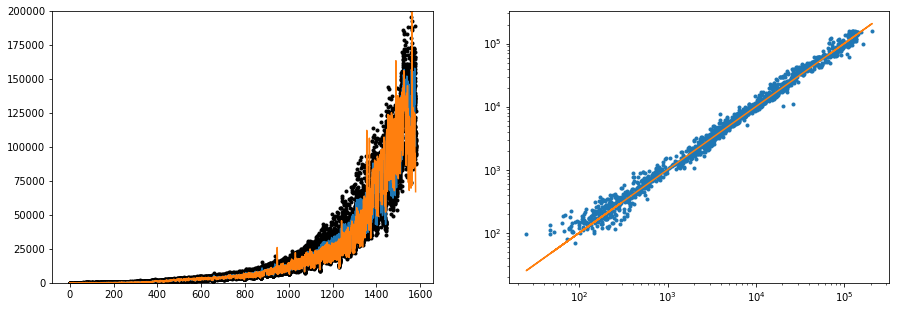

In [15]:
testset = (X_test2,test[2][:,1])

results  = numpy.zeros((testset[0].shape[0],len(models2)),dtype=numpy.float)
i=0
for m in models2:
    print("\r%d"%i,end="",flush=True)
    u = ifz(m.predict(testset[0]))[:,0]
    results[:,i] = u
    i+=1
results[results>1E6]=0
avg_result = results.dot(weights)
print("")
f, axarr = plt.subplots(1, 2,figsize=(15,5))
for i in range(results.shape[1]):
    axarr[0].plot(results[:,i],'.k')    
    print('%2d. mean square error = '%i,numpy.sqrt(numpy.mean(numpy.power(testset[1]-results[:,i],2))))
axarr[0].plot(avg_result)
axarr[0].plot(testset[1])
axarr[0].set_ylim(0,200000)
axarr[1].loglog(testset[1],avg_result,'.'),
axarr[1].loglog(testset[1],testset[1],'-')

print('ensemble mean square error = ',numpy.sqrt(numpy.mean(numpy.power(testset[1]-avg_result,2))))

Overall the no weather models looks much better. This can be a consequense of better convergence (needed more epochs for the first case).
But likely the average US weather is just not useful.

We could try to use trees to find very specific conditions (like snow storms) where the weather can prove useful. My guess there is not enough days with bad enough weather to make it visible. ... 